<font color='blue'> **08b_ Mf6 Splitter** </font>  

In [1]:
import os; import sys; import flopy ; import matplotlib.pyplot as plt ; import numpy as np
from flopy.mf6.utils import Mf6Splitter ; from flopy.plot import styles ; from flopy.utils.geometry import LineString, Polygon
from pathlib import Path ; sim_ws = Path("./08b_RES") ; sim_ws.mkdir(exist_ok=True)  ; sim_ws2 = Path("./08b_RES/Basin") ; sim_ws2.mkdir(exist_ok=True)

In [2]:
simulation_ws = Path("E:\\15_REPOS\\00_BETAMI\\bin\\Flopy_data\\mf6-freyberg")
sim = flopy.mf6.MFSimulation.load(sim_ws=simulation_ws, verbosity_level=0) ; sim.set_sim_path(sim_ws) ; sim.write_simulation(silent = True) 

In [3]:
sim.run_simulation(silent=True, report=False)

(True, [])

In [4]:
gwf = sim.get_model()  ; head = gwf.output.head().get_alldata()[-1]

In [5]:
modelgrid = gwf.modelgrid ; array = np.ones((modelgrid.nrow, modelgrid.ncol), dtype=int) ; ncol = 1
for row in range(modelgrid.nrow):
    if row != 0 and row % 2 == 0: ncol += 1
    array[row, ncol:] = 2

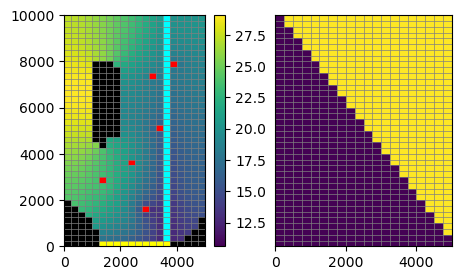

In [6]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(5, 3))
pmv = flopy.plot.PlotMapView(gwf, ax=ax0)  ; heads = gwf.output.head().get_alldata()[-1]  ; heads = np.where(heads == 1e30, np.nan, heads)
vmin = np.nanmin(heads) ; vmax = np.nanmax(heads) ; pc = pmv.plot_array(heads, vmin=vmin, vmax=vmax) ; 
pmv.plot_bc("WEL") ;pmv.plot_bc("RIV",color="cyan") ;pmv.plot_bc("CHD",color="yellow") ;pmv.plot_grid(lw=0.5) ;pmv.plot_ibound() ; plt.colorbar(pc)
pmv = flopy.plot.PlotMapView(gwf, ax=ax1) ; pc = pmv.plot_array(array) ; lc = pmv.plot_grid(lw=0.5); plt.yticks([]) ; plt.show()

In [7]:
mfsplit = Mf6Splitter(sim)                    ; new_sim = mfsplit.split_model(array)
new_sim.set_sim_path(sim_ws / "split_model")  ; new_sim.write_simulation(silent=True)  ; new_sim.run_simulation(silent=True)

(True, [])

In [8]:
ml0 = new_sim.get_model("freyberg_1")         ; heads0 = ml0.output.head().get_alldata()[-1]
ml1 = new_sim.get_model("freyberg_2")         ; heads1 = ml1.output.head().get_alldata()[-1]

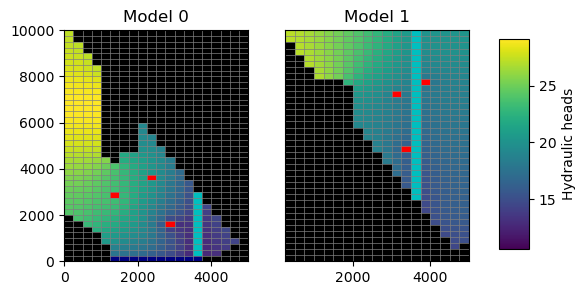

In [9]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6, 3))
pmv = flopy.plot.PlotMapView(ml0, ax=ax0) ; pmv.plot_array(heads0, vmin=vmin, vmax=vmax) ; pmv.plot_ibound() ; pmv.plot_grid(lw=0.5)
pmv.plot_bc("WEL") ; pmv.plot_bc("RIV", color="c") ; pmv.plot_bc("CHD") ; ax0.set_title("Model 0")
pmv = flopy.plot.PlotMapView(ml1, ax=ax1) ; pc = pmv.plot_array(heads1, vmin=vmin, vmax=vmax) ; pmv.plot_ibound()
pmv.plot_bc("WEL") ; pmv.plot_bc("RIV", color="c") ; pmv.plot_grid(lw=0.5) ; ax1.set_title("Model 1") ; plt.yticks([])
fig.subplots_adjust(right=0.8) ; cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7]) ; cbar = fig.colorbar(pc, cax=cbar_ax, label="Hydraulic heads") 

## <font color='red'> **Example II** </font> ... <font color='blue'> **08b_MF6 Parallel** </font> https://doi.org/10.1111/gwat.13327

In [10]:
ascii_file = Path("E:/15_REPOS/00_BETAMI/bin/Flopy_3099/fine_topo.asc")

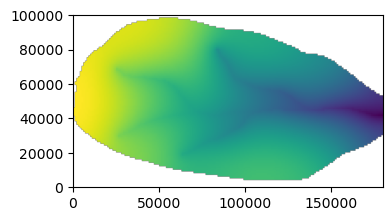

<Axes: >

In [11]:
fine_topo = flopy.utils.Raster.load(ascii_file)  ; fig = plt.figure(figsize=(4,4)); fine_topo.plot()

In [12]:
Lx = 180000 ; Ly = 100000  ; extent = (0, Lx, 0, Ly)  ; levels = np.arange(10, 110, 10) ; vmin, vmax = 0.0, 100.0

In [13]:
sys.path.append("E:/15_REPOS/00_BETAMI/bin/Flopy_functions")
from notebook_utils_beta_1 import geometries, string2geom

In [14]:
boundary_polygon = string2geom(geometries["boundary"])  ; boundary_polygon.append(boundary_polygon[0])  ; bp = np.array(boundary_polygon)
segs = [string2geom(geometries[f"streamseg{i}"]) for i in range(1, 5)]

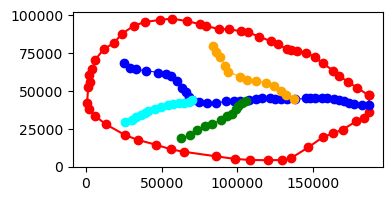

In [15]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot() ; ax.set_aspect("equal") ; riv_colors = ("blue", "cyan", "green", "orange", "red") ; ax.plot(bp[:, 0], bp[:, 1], "ro-")
for idx, seg in enumerate(segs):     sa = np.array(seg) ; ax.plot(sa[:, 0], sa[:, 1], color=riv_colors[idx], lw=0.75, marker="o")

In [16]:
dx = dy = 5000 ; dv0 = 5.0 ; nlay = 1 ; nrow = int(Ly / dy) + 1 ; ncol = int(Lx / dx) + 1
delr = np.array(ncol * [dx]) ; delc = np.array(nrow * [dy]) ; top = np.ones((nrow, ncol)) * 1000.0 ; botm = np.ones((nlay, nrow, ncol)) * -100.0
modelgrid = flopy.discretization.StructuredGrid(nlay=nlay, delr=delr, delc=delc, xoff=0, yoff=0, top=top, botm=botm)
new_top = fine_topo.resample_to_grid(modelgrid, band=fine_topo.bands[0], method="min", extrapolate_edges=True)

In [17]:
ix = flopy.utils.GridIntersect(modelgrid, method="vertex", rtree=True)     ; result = ix.intersect(Polygon(boundary_polygon))
idxs = tuple(zip(*result.cellids))  ; idomain = np.zeros((nrow, ncol), dtype=int)   ; idomain[idxs] = 1
modelgrid._idomain = idomain ; modelgrid._top = new_top

In [18]:
ixs = flopy.utils.GridIntersect(modelgrid, method="vertex")   ; cellids = []
for seg in segs: v = ixs.intersect(LineString(seg), sort_by_cellid=True) ;     cellids += v["cellids"].tolist()
intersection_rg = np.zeros(modelgrid.shape[1:])
for loc in cellids:     intersection_rg[loc] = 1

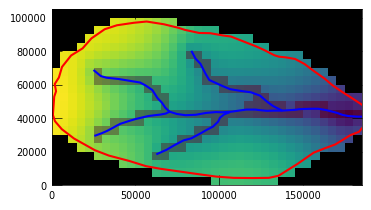

In [19]:
with styles.USGSMap():
    fig, ax = plt.subplots(figsize=(4, 4))
    pmv = flopy.plot.PlotMapView(modelgrid=modelgrid) ; ax.set_aspect("equal") ; pmv.plot_array(modelgrid.top)
    pmv.plot_array(intersection_rg,masked_values=[0,],alpha=0.2,cmap="Reds_r") ; pmv.plot_inactive() ; ax.plot(bp[:, 0], bp[:, 1], "r-")
    for seg in segs: sa = np.array(seg)  ; ax.plot(sa[:, 0], sa[:, 1], "b-")

In [20]:
nlay = 2; ixs = flopy.utils.GridIntersect(modelgrid, method="vertex")  ; drn_cellids = [] ; drn_lengths = []
for seg in segs: v=ixs.intersect(LineString(seg), sort_by_cellid=True) ; drn_cellids += v["cellids"].tolist()  ;drn_lengths += v["lengths"].tolist()
leakance = 1.0 / (0.5 * dv0)  ; drn_data = []       # kv / b
for (r, c), length in zip(drn_cellids, drn_lengths):
    x = modelgrid.xcellcenters[r, c]          ; width = 5.0 + (14.0 / Lx) * (Lx - x)
    conductance = leakance * length * width   ; drn_data.append((0, r, c, modelgrid.top[r, c], conductance))
drn_data[:10]; 

In [21]:
idomain = modelgrid.idomain.copy()  ; index = tuple(zip(*drn_cellids))  ; idomain[index] = -1      ; gw_discharge_data = []
for r in range(nrow):
    for c in range(ncol):
        if idomain[r, c] < 1:
            continue
        conductance = leakance * dx * dy   ; gw_discharge_data.append((0, r, c, modelgrid.top[r, c] - 0.5, conductance, 1.0))
gw_discharge_data[:10]

[(0, 1, 7, np.float64(99.99099731445312), 10000000.0, 1.0),
 (0, 1, 8, np.float64(98.9864730834961), 10000000.0, 1.0),
 (0, 1, 9, np.float64(97.68162536621094), 10000000.0, 1.0),
 (0, 1, 10, np.float64(96.02616882324219), 10000000.0, 1.0),
 (0, 1, 11, np.float64(93.93696594238281), 10000000.0, 1.0),
 (0, 1, 12, np.float64(91.06060028076172), 10000000.0, 1.0),
 (0, 1, 13, np.float64(87.65284729003906), 10000000.0, 1.0),
 (0, 1, 14, np.float64(86.53125), 10000000.0, 1.0),
 (0, 2, 5, np.float64(100.72657012939453), 10000000.0, 1.0),
 (0, 2, 6, np.float64(100.33457946777344), 10000000.0, 1.0)]

In [22]:
botm = np.zeros((nlay, nrow, ncol))   ; botm[0] = modelgrid.top - dv0
for ix in range(1, nlay):               dv0 *= 1.5 ; botm[ix] = botm[ix - 1] - dv0

In [23]:
idomain = np.zeros((nlay, nrow, ncol), dtype=int)  ; idomain[:] = modelgrid.idomain ; 
strt = np.zeros((nlay, nrow, ncol))                ; strt[:] = modelgrid.top

In [24]:
sim = flopy.mf6.MFSimulation(sim_name="basin",sim_ws=sim_ws2,exe_name="mf6")
flopy.mf6.ModflowTdis(sim)
flopy.mf6.ModflowIms(sim,complexity="simple",print_option="SUMMARY",linear_acceleration="bicgstab",outer_maximum=1000,
                           inner_maximum=100,outer_dvclose=1e-5,inner_dvclose=1e-6)
gwf = flopy.mf6.ModflowGwf (sim,save_flows=True,newtonoptions="NEWTON UNDER_RELAXATION")
flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,nrow=nrow,ncol=ncol,delr=dx,delc=dy,idomain=idomain,top=modelgrid.top,botm=botm,xorigin=0.0,yorigin=0.0)
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
flopy.mf6.ModflowGwfnpf (gwf,save_specific_discharge=True,icelltype=1,k=1.0)
flopy.mf6.ModflowGwfsto (gwf,iconvert=1,ss=1e-5,sy=0.2,steady_state=True,)
flopy.mf6.ModflowGwfrcha(gwf,recharge=0.000001)
flopy.mf6.ModflowGwfdrn (gwf,stress_period_data=drn_data,pname="river")
flopy.mf6.ModflowGwfdrn (gwf,auxiliary=["depth"],auxdepthname="depth",stress_period_data=gw_discharge_data,pname="gwd")
oc = flopy.mf6.ModflowGwfoc(gwf,head_filerecord=f"{gwf.name}.hds",budget_filerecord=f"{gwf.name}.cbc",saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
                            printrecord=[("BUDGET", "ALL")])

In [25]:
sim.write_simulation(silent=True)    ; sim.run_simulation(silent=True) 

(True, [])

In [26]:
water_table = flopy.utils.postprocessing.get_water_table(gwf.output.head().get_data())
heads = gwf.output.head().get_data()  ; hmin, hmax = water_table.min(), water_table.max()  ; contours = np.arange(0, 100, 10)  ; hmin, hmax

(np.float64(1.1351828297118696), np.float64(105.96803703036794))

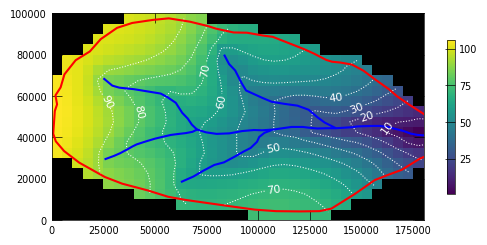

In [27]:
with styles.USGSMap():
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot()  ; ax.set_xlim(0, Lx) ; ax.set_ylim(0, Ly) ; ax.set_aspect("equal")
    pmv = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, ax=ax)  ; h = pmv.plot_array(heads, vmin=hmin, vmax=hmax)
    c = pmv.contour_array(water_table,levels=contours,colors="white",linewidths=0.75,linestyles=":")
    plt.clabel(c, fontsize=8) ; pmv.plot_inactive() ; plt.colorbar(h, ax=ax, shrink=0.5) ; ax.plot(bp[:, 0], bp[:, 1], "r-")
    for seg in segs: sa = np.array(seg)  ; ax.plot(sa[:, 0], sa[:, 1], "b-")

### <font color='red'> **Split the watershed model** </font> ...

In [28]:
nrow_blocks, ncol_blocks = 2, 4  ; row_inc, col_inc = int(nrow / nrow_blocks), int(ncol / ncol_blocks)  ; row_inc, col_inc

(10, 9)

In [29]:
icnt = 0                                       ; row_blocks = [icnt]
for i in range(nrow_blocks):  icnt += row_inc  ; row_blocks.append(icnt)
if row_blocks[-1] < nrow:    row_blocks[-1] = nrow
row_blocks

[0, 10, 21]

In [30]:
icnt = 0                                      ; col_blocks = [icnt]
for i in range(ncol_blocks): icnt += col_inc  ; col_blocks.append(icnt)
if col_blocks[-1] < ncol:                       col_blocks[-1] = ncol
col_blocks

[0, 9, 18, 27, 37]

In [31]:
mask = np.zeros((nrow, ncol), dtype=int)

In [32]:
ival = 1   ; model_row_col_offset = {}
for idx in range(len(row_blocks) - 1):
    for jdx in range(len(col_blocks) - 1):
        mask[row_blocks[idx] : row_blocks[idx + 1],col_blocks[jdx] : col_blocks[jdx + 1]] = ival
        model_row_col_offset[ival - 1] = (row_blocks[idx], col_blocks[jdx])   ; ival += 1

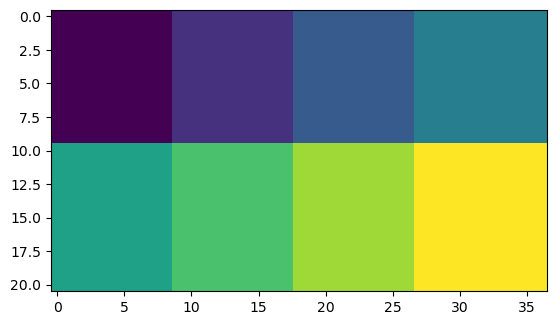

In [33]:
plt.imshow(mask)

### Now split the model into many models using `Mf6Splitter()`

In [34]:
mfsplit = Mf6Splitter(sim)  ; new_sim = mfsplit.split_model(mask)

In [35]:
new_ws = sim_ws / "split_models"  ; new_sim.set_sim_path(new_ws)  ; new_sim.write_simulation(silent=True) ; new_sim.run_simulation(silent=True)

(True, [])

In [36]:
model_names = list(new_sim.model_names)  ; head_dict = {}
for modelname in model_names:
    mnum = int(modelname.split("_")[-1]) ; head = new_sim.get_model(modelname).output.head().get_alldata()[-1] ; head_dict[mnum] = head

In [37]:
ra_heads = mfsplit.reconstruct_array(head_dict)     ; ra_watertable = flopy.utils.postprocessing.get_water_table(ra_heads)

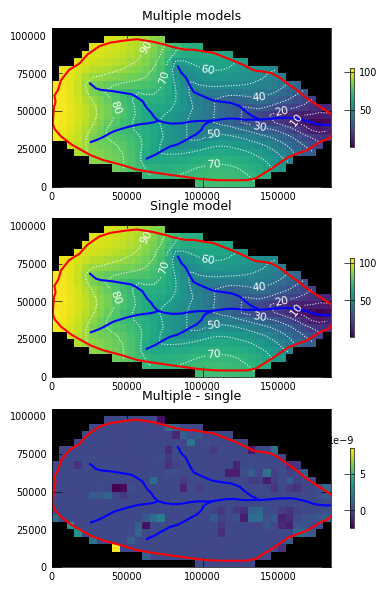

In [38]:
with styles.USGSMap():
    fig, axs = plt.subplots(nrows=3, figsize=(5, 7))  ; 
    diff = ra_heads - heads ; hv = [ra_heads, heads, diff] ; titles = ["Multiple models", "Single model", "Multiple - single"]
    for idx, ax in enumerate(axs): 
        ax.set_aspect("equal") ; ax.set_title(titles[idx])
        if idx < 2:      levels = contours ; vmin = hmin ; vmax = hmax
        else:            levels = None ; vmin = None ; vmax = None
        pmv = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, ax=ax, layer=0)  ; h = pmv.plot_array(hv[idx], vmin=vmin, vmax=vmax)
        if levels is not None: c = pmv.contour_array(hv[idx],levels=levels,colors="white",linewidths=0.75,linestyles=":")  ; plt.clabel(c, fontsize=8)
        pmv.plot_inactive() ; plt.colorbar(h, ax=ax, shrink=0.5)

        ax.plot(bp[:, 0], bp[:, 1], "r-")
        for seg in segs:             sa = np.array(seg) ; ax.plot(sa[:, 0], sa[:, 1], "b-")

### <font color='red'> **Example 3: Optimizing** </font> ...

In [39]:
## conda activate gw3099

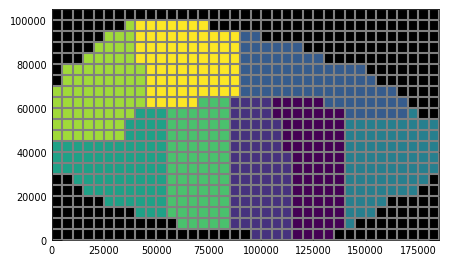

In [40]:
mfsplit = Mf6Splitter(sim)  ; split_array = mfsplit.optimize_splitting_mask(nparts=8)
with styles.USGSMap():
    fig,ax=plt.subplots(figsize=(5, 3)) ;pmv = flopy.plot.PlotMapView(gwf,ax=ax) ;pmv.plot_array(split_array) ;pmv.plot_inactive() ;pmv.plot_grid()

In [41]:
new_sim = mfsplit.split_model(split_array)  ; new_ws = sim_ws / "opt_split_models"
new_sim.set_sim_path(new_ws)                ; new_sim.write_simulation(silent=True) ; new_sim.run_simulation(silent=True)

(True, [])

In [42]:
model_names = list(new_sim.model_names)  ; head_dict = {}
for modelname in model_names:
    mnum = int(modelname.split("_")[-1])  ; head = new_sim.get_model(modelname).output.head().get_alldata()[-1] ; head_dict[mnum] = head

In [43]:
ra_heads = mfsplit.reconstruct_array(head_dict)  ; ra_watertable = flopy.utils.postprocessing.get_water_table(ra_heads)

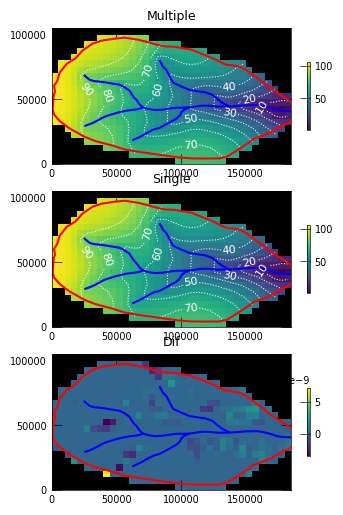

In [44]:
with styles.USGSMap():
    fig, axs = plt.subplots(nrows=3, figsize=(4, 6))  ; diff = ra_heads - heads  ; hv = [ra_heads, heads, diff]; titles = ["Multiple","Single","Dif"]
    for idx, ax in enumerate(axs): 
        ax.set_aspect("equal") ; ax.set_title(titles[idx])
        if idx < 2: levels = contours ; vmin = hmin ; vmax = hmax
        else:       levels = None ; vmin = None ; vmax = None
        pmv = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, ax=ax, layer=0)  ; h = pmv.plot_array(hv[idx], vmin=vmin, vmax=vmax)
        if levels is not None: c = pmv.contour_array(hv[idx],levels=levels,colors="white",linewidths=0.75,linestyles=":")  ;plt.clabel(c, fontsize=8)
        pmv.plot_inactive() ; plt.colorbar(h, ax=ax, shrink=0.5)
        ax.plot(bp[:, 0], bp[:, 1], "r-")
        for seg in segs: sa = np.array(seg)  ;             ax.plot(sa[:, 0], sa[:, 1], "b-")